In [159]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant



#### --------- Definition of variables ------------------------

N_size=5001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)
    
def Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
        m_sin=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
    Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
    return Fourier_plus,Fourier_minous

def Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size,Ground=False):
    if Ground:
        F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground=Ground)
    else:
        F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size)
    return F_plus[(N_size-1)//2-L//2:(N_size-1)//2+L//2+1], F_minous[(N_size-1)//2-L//2:(N_size-1)//2+L//2+1]
def Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size,Ground=False):
    if Ground:
        circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size,Ground=Ground)
    else:
        circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size)
    return (Create_circulant(circulant)+Create_anti_circulant(anticirculant))/N_size

In [160]:
n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
mu=0

# Something is wrong since we shouldn't take a circulant of the matrix, this matrix construction has to be toeplitz

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in log


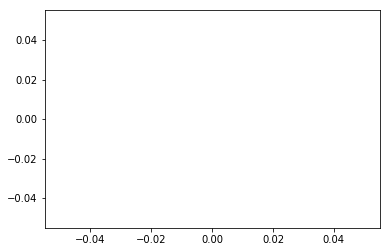

In [163]:
result=[]
for i in range(5, 50):
    New_Cov_matrix=Covariance_matrix(i,beta,mu,Lambda,Gamma,N_size,Ground=True)
    A,S,B=np.linalg.svd(New_Cov_matrix)
    aux=np.sum(Binary_entropy((S+0.5))) 
    result.append(aux)
plt.plot(result)

array([-50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40.,
       -39., -38., -37., -36., -35., -34., -33., -32., -31., -30., -29.,
       -28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.,  50.])

# Prueba valentina

In [48]:
def Compute_entropy(data):
    similarities_matrix=[]
    for i in range(data.shape[0]):
        similarities=[]
        for j in range(i+1,data.shape[0]):
            #print("Comparacion de fila {} con fila {}".format(i,j))
            #print("Similaridad = {}".format(np.sum(data[i]==data[j])/data.shape[1]))
            similarities.append(np.sum(data[i]==data[j])/data.shape[1])
        if i+1==data.shape[0]:
            break
        similarities_matrix.append(similarities)
    entropy=0
    for i in similarities_matrix:
        for j in i:
            if j==0 or j==1:
                entropy+=0
            else:    
                entropy+=(-j*np.log(j)-(1-j)*np.log(1-j))
    return entropy

In [89]:
data=data8.copy()
s_init=Compute_entropy(data)
f=0
aux=0
ranking=[]
while f<=data.shape[1]:
    s_f=Compute_entropy(np.delete(data,aux,axis=1))
    print(s_f,s_init,aux)
    if  s_f<s_init:
        ranking.append(aux+f)
        print("entro")
        s_init=s_f
        data=np.delete(data,aux,axis=1)
        aux=0
        f+=1
        if f==data.shape[1]-1:
            break
    else:
        print("probando otro")
        aux+=1
    if s_f ==0:
        print("Se alcanzó minima entropía")
        break

6.365141682948128 5.884975518070358 0
probando otro
6.365141682948128 5.884975518070358 1
probando otro
3.8190850097688767 5.884975518070358 2
entro
4.1588830833596715 3.8190850097688767 0
probando otro
4.1588830833596715 3.8190850097688767 1
probando otro
0 3.8190850097688767 2
entro
Se alcanzó minima entropía


In [87]:
ranking

[2, 3]

In [91]:
Binary_entropy([0.5])

array([0.69314718])

In [92]:
-0.5*np.log(0.5)-(1-0.5)*np.log(1-0.5)

0.6931471805599453

# Code that now works perfectly

In [208]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant



#### --------- Definition of variables ------------------------

N_size=5001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)
    
def Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
        m_sin=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
    Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
    return Fourier_plus,Fourier_minous

def Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size,Ground=False):
    if Ground:
        F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground=Ground)
    else:
        F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size)
    return F_plus[(N_size-1)//2-L+1:(N_size-1)//2+L], F_minous[(N_size-1)//2-L+1:(N_size-1)//2+L]

def Toeplitz_matrix(array,L):
    Toeplitz=np.zeros((L,L),dtype=np.complex)
    aux=0
    for i in range(L):
        #print(array[aux:aux+L][::-1].shape)
        Toeplitz[:,i]=array[aux:aux+L][::-1]
        aux+=1
    return Toeplitz
def Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size,Ground=False):
    if Ground:
        circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size,Ground=Ground)
    else:
        circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size)
    return (Toeplitz_matrix(circulant,L)+Toeplitz_matrix(anticirculant,L))/N_size

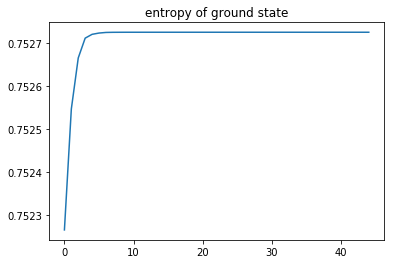

In [217]:
n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
mu=0
result=[]
for i in range(5, 50):
    New_Cov_matrix=Covariance_matrix(i,beta,mu,Lambda,Gamma,N_size,Ground=True)
    A,S,B=np.linalg.svd(New_Cov_matrix)
    aux=np.sum(Binary_entropy((S+0.5))) 
    result.append(aux)
plt.plot(result)
plt.title("entropy of ground state")
plt.show()

# now the entropy gives us what is suppose to give

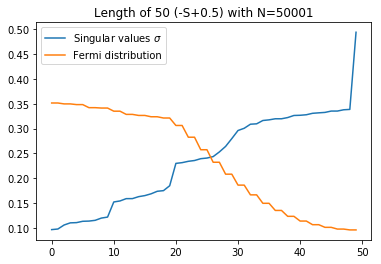

In [225]:
L=50
N_size=50001 #
Gamma=0.5
Lambda=0.5
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
A,S,B=np.linalg.svd(Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size))
plt.title("Length of {} (-S+0.5) with N={}".format(L,N_size))
plt.plot(-S+0.5,label=r"Singular values $\sigma$")
n=np.arange(-(L-1)/2,(L-1)/2 +1)
plt.plot(np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)),label="Fermi distribution")
plt.legend()
plt.show()

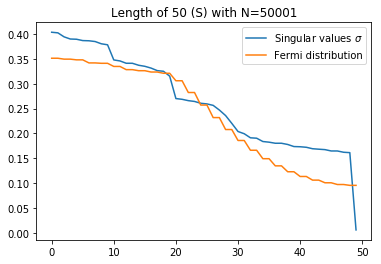

In [226]:
plt.title("Length of {} (S) with N={}".format(L,N_size))
plt.plot((S),label=r"Singular values $\sigma$")
n=np.arange(-(L-1)/2,(L-1)/2 +1)
plt.plot(np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)),label="Fermi distribution")
plt.legend()
plt.show()

# entropy of generic state

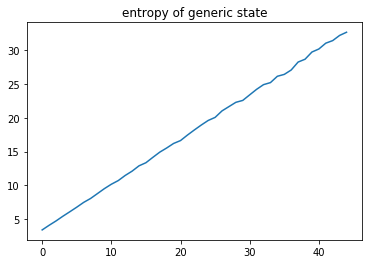

In [218]:
N_size=5001
n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
mu=0
result=[]
for i in range(5, 50):
    New_Cov_matrix=Covariance_matrix(i,beta,mu,Lambda,Gamma,N_size,Ground=False)
    A,S,B=np.linalg.svd(New_Cov_matrix)
    aux=np.sum(Binary_entropy((S+0.5))) 
    result.append(aux)
plt.plot(result)
plt.title("entropy of generic state")
plt.show()

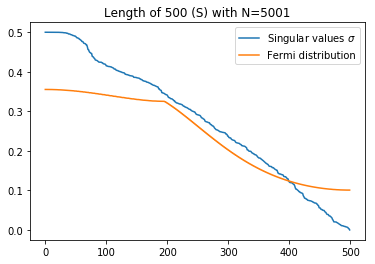

In [222]:
L=500
Gamma=0.5
Lambda=0.5
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
A,S,B=np.linalg.svd(Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size))
plt.title("Length of {} (S) with N={}".format(L,N_size))
plt.plot(S,label=r"Singular values $\sigma$")
n=np.arange(-(L-1)/2,(L-1)/2 +1)
plt.plot(np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)),label="Fermi distribution")
plt.legend()
plt.show()